# Qur'an Semantic Search — End-to-End Builder (Ready-to-Run)
**Purpose:** Rebuild `links.json`, `links_cosine.json`, `links_bm25.json` reliably for the HTML viewer.

Run all cells **top to bottom**. If you are in Google Colab, keep your Drive mounted.


In [ ]:
# ==== Cell 1 — Environment & Paths (GitHub-friendly) ====
import sys, subprocess, os, json, re, datetime
from pathlib import Path

# Project root = current working directory when run
ROOT = Path.cwd()

# Use repo-relative folders
DATA_DIR     = ROOT / "data"
ART_DIR      = ROOT / "artifacts"
DATA_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR.mkdir(parents=True, exist_ok=True)

# Key files
QURAN_CSV    = DATA_DIR / "quran.csv"
QURAN_XML    = DATA_DIR / "quran-simple.xml"   # optional fallback if you add it later
EMB_PATH     = DATA_DIR / "embeddings_e5_small.npy"   # cached embeddings (small; safe in Git)
LINKS_HYBRID = ART_DIR / "links.json"
LINKS_COSINE = ART_DIR / "links_cosine.json"
LINKS_BM25   = ART_DIR / "links_bm25.json"

# Retrieval config
ALPHA           = 0.8
TOP_K           = 20
GENERATE_LIMIT  = None  # e.g. 500 for a quick run; None = all

def ensure(pkg, import_name=None, version=None):
    import importlib, subprocess, sys
    name = import_name or pkg
    try:
        importlib.import_module(name); return
    except Exception:
        args = [sys.executable, "-m", "pip", "install", "--no-cache-dir", "--upgrade"]
        args.append(f"{pkg}=={version}" if version else pkg)
        print("> pip", " ".join(args[3:]))
        subprocess.check_call(args)
        importlib.invalidate_caches()
        importlib.import_module(name)

print("DATA_DIR =", DATA_DIR)
print("ART_DIR  =", ART_DIR)


Mounted at /content/drive
✅ Colab detected; Drive mounted.
DATA_DIR = /content/drive/My Drive/999. MS/10. Project/quran_semantic_data


In [ ]:
# ============================================================
# Cell 2 — Minimal stack & imports (Py3.12 safe)
#  * Numeric/data basics
#  * BM25
#  * HF + Torch stack (CPU) with compatible pins
# ============================================================
# Numeric / data
ensure("numpy", version="2.1.3")
ensure("pandas", version="2.2.3")
ensure("scikit-learn", import_name="sklearn", version="1.5.2")

# rank-bm25 (install separately to avoid resolver hiccups)
try:
    import rank_bm25
except ImportError:
    # separate install avoids conflicts
    get_ipython().system("pip install --no-cache-dir rank-bm25==0.2.2 -q")
    import rank_bm25

# Torch + HF stack (CPU-only)
get_ipython().system("pip install --no-cache-dir --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu -q")
get_ipython().system("pip install --no-cache-dir --upgrade sentence-transformers==2.7.0 transformers==4.57.1 tokenizers==0.22.1 huggingface-hub==0.36.0 accelerate==0.34.2 safetensors==0.4.5 -q")

# Imports
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **k: x  # fallback
print("✅ Imports ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 MB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 155.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.6/495.6 kB 151.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 348.9 MB/s eta 0:00:00
✅ Imports ready.


In [ ]:
# ============================================================
# Cell 3 — Load Qur'an corpus
#  * Prefer quran.csv (surah, ayah, arabic_text)
#  * Fallback: build from quran-simple.xml (Tanzil)
# ============================================================
def build_csv_from_tanzil(xml_path: Path, out_csv: Path):
    import xml.etree.ElementTree as ET
    root = ET.parse(xml_path).getroot()
    rows = []
    for s in root.iter('sura'):
        s_no = int(s.attrib.get('index'))
        for a in s.iter('aya'):
            a_no = int(a.attrib.get('index'))
            text = a.attrib.get('text', '')
            rows.append((s_no, a_no, text))
    df_ = pd.DataFrame(rows, columns=['surah','ayah','arabic_text'])
    df_.to_csv(out_csv, index=False, encoding='utf-8')
    print(f"Built {out_csv} from {xml_path} (rows={len(df_)})")
    return out_csv

if not QURAN_CSV.exists():
    if QURAN_XML.exists():
        print("quran.csv not found; building from quran-simple.xml ...")
        build_csv_from_tanzil(QURAN_XML, QURAN_CSV)
    else:
        raise FileNotFoundError(f"Missing {QURAN_CSV} (and fallback {QURAN_XML} not present)")

df = pd.read_csv(QURAN_CSV)
for col in ["surah","ayah","arabic_text"]:
    assert col in df.columns, f"Missing column: {col}"

# Key "s:a"
df["key"] = df["surah"].astype(int).astype(str) + ":" + df["ayah"].astype(int).astype(str)

# Arabic normalization (lightweight but consistent)
_ar_diacritics = re.compile(r"[\u0610-\u061A\u064B-\u065F\u06D6-\u06ED]")
def normalize_arabic(s: str) -> str:
    s = str(s)
    s = _ar_diacritics.sub("", s)    # remove diacritics
    s = s.replace("\u0640", "")      # tatweel
    s = re.sub("[إأآ]", "ا", s)      # unify alif forms
    s = s.replace("ؤ","و").replace("ئ","ي").replace("ى","ي").replace("ة","ه")
    return s


df["norm"] = df["arabic_text"].fillna("").map(normalize_arabic)
print("Loaded verses:", len(df))
df.head(3)


Loaded verses: 6236


,surah,ayah,arabic_text,key,norm
0,1,1,بِسْمِ اللَّهِ الرَّحْمَـٰنِ الرَّحِيمِ,1:1,بسم الله الرحمٰن الرحيم
1,1,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,1:2,الحمد لله رب العالمين
2,1,3,الرَّحْمَـٰنِ الرَّحِيمِ,1:3,الرحمٰن الرحيم


In [ ]:
# ============================================================
# Cell 4 — BM25 baseline
#  * Tokenize normalized Arabic and build BM25Okapi
# ============================================================
def simple_tok(s: str):
    return [t for t in re.split(r"\W+", s) if t]

corpus_tokens = [simple_tok(t) for t in df["norm"].tolist()]
bm25 = BM25Okapi(corpus_tokens)
print("BM25 ready: documents =", len(corpus_tokens))


BM25 ready: documents = 6236


In [ ]:
# ============================================================
# Cell 5 — Embeddings
#  * Load cached embeddings if present; else compute & save
#  * Normalize embeddings so dot = cosine
# ============================================================
if EMB_PATH.exists():
    emb = np.load(EMB_PATH)
    assert emb.shape[0] == len(df), f"Embeddings rows {emb.shape[0]} != verses {len(df)}"
    print("Loaded embeddings:", EMB_PATH, emb.shape)
else:
    model = SentenceTransformer("intfloat/multilingual-e5-small")
    texts = df["norm"].tolist()
    emb = model.encode(texts, batch_size=64, normalize_embeddings=True, convert_to_numpy=True)
    np.save(EMB_PATH, emb)
    print("Computed & saved embeddings:", EMB_PATH, emb.shape)

# Cosine similarity will be dot product because vectors are normalized


Loaded embeddings: /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/embeddings_e5_small.npy (6236, 384)


In [ ]:
# ============================================================
# Cell 6 — Helpers
#  * minmax_with_tie_cap: per-query normalization w/ rank fallback
#  * fused_score: hybrid fusion
#  * exact-match: normalized text equality badge
# ============================================================
from typing import List
import numpy as np

def minmax_with_tie_cap(v: List[float], *, eps: float = 1e-9,
                        tie_thresh: float = 1e-9,
                        use_rank_if_flat: bool = True) -> List[float]:
    """Min–max to [0,1]; if nearly flat, use rank-based scaling to avoid many 1.0 ties."""
    if not v:
        return []
    v = np.asarray(v, dtype=float)
    vmin, vmax = float(np.nanmin(v)), float(np.nanmax(v))
    rng = vmax - vmin
    if not np.isfinite(vmin) or not np.isfinite(vmax) or rng < tie_thresh:
        if use_rank_if_flat:
            order = np.argsort(-v)  # descending
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(v), dtype=float)  # 0..N-1
            if len(v) == 1:
                out = np.array([1.0], dtype=float)
            else:
                out = 1.0 - (ranks / (len(v)-1))
            return out.tolist()
        else:
            # tiny jitter
            noise = np.linspace(0.0, 1e-4, num=len(v))
            return (noise / max(1e-9, noise.max())).tolist()
    return ((v - vmin) / max(rng, eps)).tolist()

def fused_score(cos_norm: float, bm25_norm: float, alpha: float = 0.8) -> float:
    return float(alpha * cos_norm + (1.0 - alpha) * bm25_norm)

# Map key -> original Arabic (for exact-match badge)
KEY2TXT = dict(zip(df["key"], df["arabic_text"]))
def is_identical_text(k1: str, k2: str) -> bool:
    if k1 == k2:  # we never show self-link; treat as not "identical" badge
        return False
    return normalize_arabic(KEY2TXT.get(k1, "")) == normalize_arabic(KEY2TXT.get(k2, ""))

    # --- NEW: tokenization helper reused from BM25 ---
def simple_tok(s: str):
    return [t for t in re.split(r"\W+", s) if t]

def jaccard_overlap(a: set, b: set) -> float:
    if not a or not b: return 0.0
    inter = len(a & b); union = len(a | b)
    return inter / union if union else 0.0



In [ ]:
# ============================================================
# Cell 7 — Build neighbors (Hybrid + Cosine + BM25) and export
#  * Keep raw and normalized values
#  * Add "identical" and "overlap" fields
#  * Gate hybrid score by lexical overlap
#  * Write three JSONs with meta
# ============================================================
N = len(df)
keys = df["key"].tolist()

row_indices = list(range(N))
if isinstance(GENERATE_LIMIT, int) and GENERATE_LIMIT > 0:
    row_indices = row_indices[:GENERATE_LIMIT]

links_hybrid, links_cos, links_bm = {}, {}, {}

for i in tqdm(row_indices, desc="Building neighbors"):
    # ----- Raw signals -----
    cos_raw = emb @ emb[i]                       # raw cosine (dot) per doc
    q_tokens = corpus_tokens[i]                  # query = tokens of verse i
    q_set = set(q_tokens)
    bm25_raw = np.asarray(BM25Okapi.get_scores(bm25, q_tokens), dtype=float)

    # Remove self-link
    cos_raw[i]  = -1.0
    bm25_raw[i] = -np.inf

    # ----- Normalized per query (with tie handling) -----
    cos_n  = np.asarray(minmax_with_tie_cap(cos_raw.tolist()), dtype=float)
    bm25_clamped = np.maximum(bm25_raw, 0.0)      # clamp then scale
    bm25_n = np.asarray(minmax_with_tie_cap(bm25_clamped.tolist()), dtype=float)

    # ----- Combined hybrid score (with overlap gate) -----
    # NOTE: overlap is computed per-candidate below, so gating is applied after we compute it
    fused = ALPHA * cos_n + (1.0 - ALPHA) * bm25_n

    # ----- Top-K selection by fused score -----
    K = min(TOP_K, len(keys) - 1)
    top_idx = np.argpartition(-fused, range(K))[:K]
    top_idx = top_idx[np.argsort(-fused[top_idx])]

    qkey = keys[i]
    rows_h, rows_c, rows_b = [], [], []

    for j in top_idx:
        vkey = keys[j]
        cand_tokens = corpus_tokens[j]
        overlap = jaccard_overlap(q_set, set(cand_tokens))  # 0..1

        # Apply overlap gate here to fused[j]
        fused_j = fused[j] * (0.2 + 0.8 * overlap)

        rows_h.append({
            "id": vkey,
            "score": float(fused_j),
            "cos": float(cos_n[j]),
            "cos_raw": float(cos_raw[j]),
            "bm25": float(bm25_n[j]),
            "bm25_raw": float(bm25_raw[j]) if np.isfinite(bm25_raw[j]) else 0.0,
            "overlap": float(overlap),
            "identical": bool(is_identical_text(qkey, vkey))
        })
        rows_c.append({
            "id": vkey,
            "score": float(cos_n[j]),
            "cos": float(cos_n[j]),
            "cos_raw": float(cos_raw[j]),
            "overlap": float(overlap),
            "identical": bool(is_identical_text(qkey, vkey))
        })
        rows_b.append({
            "id": vkey,
            "score": float(bm25_n[j]),
            "bm25": float(bm25_n[j]),
            "bm25_raw": float(bm25_raw[j]) if np.isfinite(bm25_raw[j]) else 0.0,
            "overlap": float(overlap),
            "identical": bool(is_identical_text(qkey, vkey))
        })

    # Store per-query lists
    links_hybrid[qkey] = rows_h
    links_cos[qkey]    = rows_c
    links_bm[qkey]     = rows_b

# ----- Metadata -----
meta = {
    "alpha": float(ALPHA),
    "top_k": int(TOP_K),
    "gate_overlap": True,
    "overlap_gate_formula": "score *= (0.2 + 0.8*overlap)",
    "timestamp": str(datetime.date.today())
}

def save_with_meta(path: Path, payload: dict):
    with open(path, "w", encoding="utf-8") as f:
        json.dump({"meta": meta, **payload}, f, ensure_ascii=False, indent=2)
    print(f"✅ wrote {path} (keys: {len(payload)})")

# ----- Save outputs -----
save_with_meta(LINKS_HYBRID, links_hybrid)
save_with_meta(LINKS_COSINE, links_cos)
save_with_meta(LINKS_BM25,   links_bm)


Building neighbors: 100%|██████████| 6236/6236 [05:07<00:00, 20.28it/s]


✅ wrote /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/links.json (keys: 6236)
✅ wrote /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/links_cosine.json (keys: 6236)
✅ wrote /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/links_bm25.json (keys: 6236)


In [ ]:
# ============================================================
# Cell 8 — Sanity check
#  * Confirm non-empty and print a small sample (with raw values)
# ============================================================
for p in [LINKS_HYBRID, LINKS_COSINE, LINKS_BM25]:
    obj = json.loads(p.read_text(encoding="utf-8"))
    data = {k:v for k,v in obj.items() if k != "meta"}
    print(p.name, "keys:", len(data))
    if data:
        k0 = next(iter(data.keys()))
        print(" sample key:", k0)
        print(" first 2 neighbors:")
        for row in data[k0][:2]:
            print("  ", {k: row[k] for k in row if k in ["id","score","cos","cos_raw","bm25","bm25_raw","identical"]})


links.json keys: 6236
 sample key: 1:1
 first 2 neighbors:
   {'id': '27:30', 'score': 0.6287833933263205, 'cos': 0.9696229611932939, 'cos_raw': 0.9175143837928772, 'bm25': 1.0, 'bm25_raw': 26.871746738245918, 'identical': False}
   {'id': '1:3', 'score': 0.6579720658891357, 'cos': 1.0, 'cos_raw': 0.9775876402854919, 'bm25': 0.8380298962436452, 'bm25_raw': 22.51932713093774, 'identical': False}
links_cosine.json keys: 6236
 sample key: 1:1
 first 2 neighbors:
   {'id': '27:30', 'score': 0.9696229611932939, 'cos': 0.9696229611932939, 'cos_raw': 0.9175143837928772, 'identical': False}
   {'id': '1:3', 'score': 1.0, 'cos': 1.0, 'cos_raw': 0.9775876402854919, 'identical': False}
links_bm25.json keys: 6236
 sample key: 1:1
 first 2 neighbors:
   {'id': '27:30', 'score': 1.0, 'bm25': 1.0, 'bm25_raw': 26.871746738245918, 'identical': False}
   {'id': '1:3', 'score': 0.8380298962436452, 'bm25': 0.8380298962436452, 'bm25_raw': 22.51932713093774, 'identical': False}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using golden CSV: /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/golden (061100 Nov 25).csv
Using links_cosine: /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/links_cosine.json
Using links_bm25 : /content/drive/My Drive/999. MS/10. Project/quran_semantic_data/links_bm25.json
Gold queries total: 356 | Covered by links: 356 (100.0%)
Avg candidate lengths — cosine: 20.0, bm25: 20.0, union: 20.0
Retrievability (union of cosine+bm25 contains gold positives): 100.0%
=== Hybrid Evaluation Report ===
Golden CSV: golden (061100 Nov 25).csv
Links: cosine=links_cosine.json, bm25=links_bm25.json

Gold queries: 356 | Covered in links: 356 (100.0%)
Avg candidate sizes — cosine: 20.0, bm25: 20.0, union: 20.0
Retrievability (union contains gold positives): 100.0%

Top-line (best over α):
  Best α by NDCG: 0.80  (NDCG=0.9979)
  Best α by MAP 

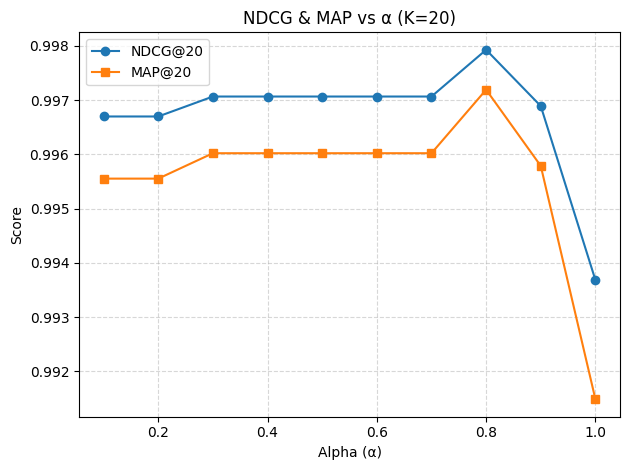

In [ ]:
# ============================================
# Cell 9 — Extended Evaluation Suite (α sweep)
#  - Keeps original NDCG/MAP vs α
#  - Adds: Precision@K, Recall@K, HitRate@K, MRR@K, R-Precision
#  - Adds diagnostics: links coverage, retrievability/union coverage, candidate stats
#  - Outputs:
#       1) alpha_scores.csv  (all metrics by α)
#       2) alpha_ndcg_map.png (plot)
#       3) evaluation_report.txt (single, readable report with diagnostics)
# ============================================

import os, re, json, csv, math, statistics as stats
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from pathlib import Path

# --------- CONFIG ----------
USE_GOOGLE_DRIVE = True
GDRIVE_GOLD_DIR  = "/content/drive/My Drive/999. MS/10. Project/quran_semantic_data"
GOLDEN_CANDIDATES = [
    "golden_clean.csv",            # if you created a cleaned file earlier
    "golden (061100 Nov 25).csv",  # your uploaded name
    "golden.csv",
]
SEARCH_DIRS = [Path.cwd(), Path(GDRIVE_GOLD_DIR), Path("/mnt/data")]
ALPHAS = [x/10 for x in range(1,11)]   # 0.1..1.0
K      = 20
PLOT_ALPHA_MARKERS = True  # show points on curves

# --------- Drive (soft mount) ----------
if USE_GOOGLE_DRIVE:
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
    except Exception as e:
        print("Drive mount note:", e)

# --------- Helpers ----------
_key_re = re.compile(r'^[1-9]\d*:[1-9]\d*$')

def _norm_key(s: str) -> str:
    """Normalize to 'S:A' (remove quotes/spaces/leading zeros on both sides)."""
    s = (str(s) if s is not None else "").strip()
    s = s.replace('"','').replace("'","").replace(" ", "")
    m = re.match(r'^0*([1-9]\d*)\s*:\s*0*([1-9]\d*)$', s)
    return f"{int(m.group(1))}:{int(m.group(2))}" if m else s

def parse_rel_list(s: str) -> Dict[str, float]:
    """Parse '2:153|3:200|2:286(2)' -> {'2:153':1.0,'3:200':1.0,'2:286':2.0} (normalized)."""
    out = {}
    if not s: return out
    for chunk in str(s).split('|'):
        c = (chunk or "").strip()
        if not c:
            continue
        if '(' in c and c.endswith(')'):
            try:
                key, g = c[:-1].split('(')
                out[_norm_key(key)] = float(g)
            except Exception:
                out[_norm_key(c)] = 1.0
        else:
            out[_norm_key(c)] = 1.0
    # keep only well-formed ids
    return {k:v for k,v in out.items() if _key_re.match(k)}

def find_file(filename_candidates, search_dirs):
    for d in search_dirs:
        for cand in filename_candidates:
            p = d / cand
            if p.exists(): return p
            for g in d.glob(cand):
                if g.exists(): return g
    return None

def normalize_links_obj(raw: dict, mode: str) -> Dict[str, List[dict]]:
    """Return { 's:a': [ {id, cos?, bm25?, score?} ] }, tolerating your JSON shapes."""
    def nkey(x):
        return _norm_key(x) if x is not None else ""
    src = {k:v for k,v in raw.items() if k != 'meta'}
    out = {}
    for k, arr in src.items():
        kk = nkey(k)
        if not _key_re.match(kk):
            continue
        rows = []
        if isinstance(arr, list):
            for e in arr:
                if isinstance(e, dict):
                    vid = nkey(e.get('id') or e.get('key') or '')
                    if not _key_re.match(vid) or vid == kk:
                        continue
                    cos = e.get('cos'); bm = e.get('bm25') or e.get('bm')
                    sc  = e.get('score')
                    if sc is None:
                        sc = cos if mode == 'cosine' else (bm if mode == 'bm25' else None)
                    rows.append({'id': vid, 'cos': cos, 'bm25': bm, 'score': sc})
                elif isinstance(e, list) and e:
                    vid = nkey(e[0]); sc = float(e[1]) if len(e)>1 else 0.0
                    if not _key_re.match(vid) or vid == kk:
                        continue
                    if mode == 'cosine':
                        rows.append({'id': vid, 'cos': sc, 'bm25': 0.0, 'score': sc})
                    else:
                        sc = max(0.0, sc)
                        rows.append({'id': vid, 'cos': 0.0, 'bm25': sc, 'score': sc})
        rows.sort(key=lambda x: (x.get('score') or 0), reverse=True)
        out[kk] = rows
    return out

def load_links_json(path_cos: Path, path_bm25: Path):
    cos_raw = json.loads(path_cos.read_text(encoding='utf-8'))
    bm_raw  = json.loads(path_bm25.read_text(encoding='utf-8'))
    return normalize_links_obj(cos_raw, 'cosine'), normalize_links_obj(bm_raw, 'bm25')

def fused_ranking_for_query(cos_rows: List[dict], bm_rows: List[dict], alpha: float, k: int) -> List[str]:
    """Union of candidates; score = α·cos + (1-α)·bm25."""
    scores = {}
    for row in cos_rows:
        vid = row['id']; c = float(row.get('cos') or row.get('score') or 0.0)
        scores[vid] = max(scores.get(vid, 0.0), alpha * c)
    for row in bm_rows:
        vid = row['id']; b = float(row.get('bm25') or row.get('score') or 0.0)
        scores[vid] = scores.get(vid, 0.0) + (1.0 - alpha) * b
    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
    return [vid for vid,_ in ranked[:k]]

# --------- Metrics (binary use rel>0; graded used in NDCG) ----------
def dcg_at_k(rels: List[float], k: int) -> float:
    return sum((rel / math.log2(i+2)) for i, rel in enumerate(rels[:k]))

def ndcg_at_k(pred_ids: List[str], rel_dict: Dict[str, float], k: int) -> float:
    gains = [rel_dict.get(v, 0.0) for v in pred_ids[:k]]
    dcg = dcg_at_k(gains, k)
    ideal = sorted(rel_dict.values(), reverse=True)
    idcg = dcg_at_k(ideal, min(k, len(ideal))) if ideal else 0.0
    return (dcg / idcg) if idcg > 0 else 0.0

def map_at_k(pred_ids: List[str], rel_dict: Dict[str, float], k: int) -> float:
    hits = 0; ap_sum = 0.0
    total_pos = sum(1 for v in rel_dict.values() if v > 0)
    if total_pos == 0: return 0.0
    for i, vid in enumerate(pred_ids[:k], start=1):
        if rel_dict.get(vid, 0.0) > 0:
            hits += 1
            ap_sum += hits / i
    return ap_sum / total_pos

def precision_at_k(pred_ids: List[str], rel_dict: Dict[str, float], k: int) -> float:
    if k == 0: return 0.0
    hits = sum(1 for vid in pred_ids[:k] if rel_dict.get(vid, 0.0) > 0)
    return hits / k

def recall_at_k(pred_ids: List[str], rel_dict: Dict[str, float], k: int) -> float:
    total_pos = sum(1 for v in rel_dict.values() if v > 0)
    if total_pos == 0: return 0.0
    hits = sum(1 for vid in pred_ids[:k] if rel_dict.get(vid, 0.0) > 0)
    return hits / total_pos

def hitrate_at_k(pred_ids: List[str], rel_dict: Dict[str, float], k: int) -> float:
    return 1.0 if any(rel_dict.get(vid, 0.0) > 0 for vid in pred_ids[:k]) else 0.0

def mrr_at_k(pred_ids: List[str], rel_dict: Dict[str, float], k: int) -> float:
    for i, vid in enumerate(pred_ids[:k], start=1):
        if rel_dict.get(vid, 0.0) > 0:
            return 1.0 / i
    return 0.0

def r_precision(pred_ids: List[str], rel_dict: Dict[str, float]) -> float:
    R = sum(1 for v in rel_dict.values() if v > 0)
    if R == 0: return 0.0
    top = pred_ids[:R]
    hits = sum(1 for vid in top if rel_dict.get(vid, 0.0) > 0)
    return hits / R

# --------- Resolve golden.csv ----------
gold_dir = Path(GDRIVE_GOLD_DIR) if USE_GOOGLE_DRIVE else Path.cwd()
gold_path = None

for name in GOLDEN_CANDIDATES:
    p = gold_dir / name
    if p.exists(): gold_path = p; break
if gold_path is None and gold_dir.exists():
    matches = sorted(gold_dir.glob("golden*.csv"))
    if matches: gold_path = matches[0]
if gold_path is None:
    mnt_matches = sorted(Path("/mnt/data").glob("golden*.csv"))
    if mnt_matches: gold_path = mnt_matches[0]

assert gold_path and gold_path.exists(), (
    f"Golden set not found. Looked in {GDRIVE_GOLD_DIR} and /mnt/data."
)
print("Using golden CSV:", gold_path)

# --------- Load & CLEAN golden.csv ----------
import pandas as pd
raw = pd.read_csv(gold_path)
cols = {c.strip().lower(): c for c in raw.columns}
assert "query_id" in cols and "positives" in cols, f"CSV must have columns: query_id, positives; got {list(raw.columns)}"

raw["query_id"]  = raw[cols["query_id"]].map(_norm_key)
raw["positives"] = raw[cols["positives"]].astype(str)
raw = raw.dropna(subset=["query_id","positives"]).reset_index(drop=True)

# Expand into dict: q -> {id:grade,...}
gold: Dict[str, Dict[str, float]] = {}
for _, r in raw.iterrows():
    q  = r["query_id"]
    rs = parse_rel_list(r["positives"])
    if _key_re.match(q) and rs:
        gold[q] = rs

if not gold:
    raise AssertionError(
        "After cleaning, your golden set has no valid rows.\n"
        "Check for empty 'positives' cells or malformed verse IDs."
    )

# --------- Find links files ----------
def find_first(patterns: List[str]) -> Path:
    for d in SEARCH_DIRS:
        for pat in patterns:
            for m in d.glob(pat):
                if m.exists():
                    return m
    return None

links_cos = find_first(["links_cosine.json", "links_cos*.json"])
links_bm  = find_first(["links_bm25.json",  "links_bm*.json"])
assert links_cos and links_cos.exists(), "links_cosine.json not found in search dirs."
assert links_bm  and links_bm.exists(),  "links_bm25.json not found in search dirs."
print("Using links_cosine:", links_cos)
print("Using links_bm25 :", links_bm)

# --------- Load links & diagnostics ----------
cos_map, bm_map = load_links_json(links_cos, links_bm)
cos_keys = set(cos_map.keys()); bm_keys = set(bm_map.keys()); any_keys = cos_keys | bm_keys

missing_q = [q for q in gold.keys() if q not in any_keys]
covered_q = [q for q in gold.keys() if q in any_keys]
links_coverage = len(covered_q) / max(1, len(gold))

# Per-query union coverage of positives (retrievability)
def union_candidates(qid: str) -> set:
    cset = set(e['id'] for e in cos_map.get(qid, []))
    bset = set(e['id'] for e in bm_map.get(qid, []))
    return cset | bset

retrievability = []
cand_len_stats = []  # (len_cos, len_bm, len_union)
for qid in covered_q:
    u = union_candidates(qid)
    rel_ids = {vid for vid, g in gold[qid].items() if g > 0}
    if rel_ids:
        retrievability.append(len(rel_ids & u) / len(rel_ids))
    cand_len_stats.append( (len(cos_map.get(qid, [])), len(bm_map.get(qid, [])), len(u)) )

avg_cos_cands = float(np.mean([c for c,_,_ in cand_len_stats])) if cand_len_stats else 0.0
avg_bm_cands  = float(np.mean([b for _,b,_ in cand_len_stats])) if cand_len_stats else 0.0
avg_u_cands   = float(np.mean([u for *_,u in cand_len_stats]))  if cand_len_stats else 0.0
mean_retrievability = float(np.mean(retrievability)) if retrievability else 0.0

print(f"Gold queries total: {len(gold)} | Covered by links: {len(covered_q)} "
      f"({links_coverage*100:.1f}%)")
if missing_q:
    print(f"⚠️ {len(missing_q)} gold queries missing in links (showing up to 8): {missing_q[:8]}")
print(f"Avg candidate lengths — cosine: {avg_cos_cands:.1f}, bm25: {avg_bm_cands:.1f}, union: {avg_u_cands:.1f}")
print(f"Retrievability (union of cosine+bm25 contains gold positives): {mean_retrievability*100:.1f}%")

# --------- Evaluation over α ----------
def evaluate_for_alpha(a: float) -> Tuple[float,float,float,float,float,float,float,int]:
    nds, mps, prs, rcs, hits, mrrs, rps = [], [], [], [], [], [], []
    used = 0
    for qid in covered_q:
        rels     = gold[qid]
        cos_rows = cos_map.get(qid, [])
        bm_rows  = bm_map.get(qid, [])
        if not cos_rows and not bm_rows:
            continue
        pred = fused_ranking_for_query(cos_rows, bm_rows, a, K)
        nds.append(ndcg_at_k(pred, rels, K))
        mps.append(map_at_k(pred, rels, K))
        prs.append(precision_at_k(pred, rels, K))
        rcs.append(recall_at_k(pred, rels, K))
        hits.append(hitrate_at_k(pred, rels, K))
        mrrs.append(mrr_at_k(pred, rels, K))
        rps.append(r_precision(pred, rels))
        used += 1
    if used == 0:
        return (0,)*7 + (0,)
    return (
        float(np.mean(nds)),
        float(np.mean(mps)),
        float(np.mean(prs)),
        float(np.mean(rcs)),
        float(np.mean(hits)),
        float(np.mean(mrrs)),
        float(np.mean(rps)),
        used
    )

rows = []
for a in ALPHAS:
    row = evaluate_for_alpha(a)
    rows.append((a, *row))

# --------- Save CSV ----------
out_csv  = gold_path.parent / "alpha_scores.csv"
with out_csv.open("w", encoding="utf-8", newline="") as f:
    w = csv.writer(f)
    w.writerow(["alpha","NDCG@K","MAP@K","P@K","R@K","HitRate@K","MRR@K","R-Prec","K","num_queries"])
    for a, nd, mp, pr, rc, hr, mrr, rp, used in rows:
        w.writerow([a, f"{nd:.6f}", f"{mp:.6f}", f"{pr:.6f}", f"{rc:.6f}",
                    f"{hr:.6f}", f"{mrr:.6f}", f"{rp:.6f}", K, used])

# --------- Plot (NDCG & MAP vs α) ----------
out_plot = gold_path.parent / "alpha_ndcg_map.png"
xs = [a for a,*_ in rows]
nd = [v for _,v, *_ in rows]
mp = [v for _,_,v, *_ in rows]
plt.figure()
plt.plot(xs, nd, marker='o' if PLOT_ALPHA_MARKERS else None, label=f'NDCG@{K}')
plt.plot(xs, mp, marker='s' if PLOT_ALPHA_MARKERS else None, label=f'MAP@{K}')
plt.xlabel("Alpha (α)"); plt.ylabel("Score"); plt.title(f"NDCG & MAP vs α (K={K})")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.savefig(out_plot, dpi=160)

# --------- Human-readable report ----------
best_ndcg_idx = int(np.argmax(nd)) if xs else 0
best_map_idx  = int(np.argmax(mp)) if xs else 0

def fmt(x):
    return f"{x:.4f}"

report_lines = []
report_lines.append("=== Hybrid Evaluation Report ===")
report_lines.append(f"Golden CSV: {gold_path.name}")
report_lines.append(f"Links: cosine={links_cos.name}, bm25={links_bm.name}")
report_lines.append("")
report_lines.append(f"Gold queries: {len(gold)} | Covered in links: {len(covered_q)} ({links_coverage*100:.1f}%)")
if missing_q:
    report_lines.append(f"Missing gold queries in links (up to 8): {missing_q[:8]}")
report_lines.append(f"Avg candidate sizes — cosine: {avg_cos_cands:.1f}, bm25: {avg_bm_cands:.1f}, union: {avg_u_cands:.1f}")
report_lines.append(f"Retrievability (union contains gold positives): {mean_retrievability*100:.1f}%")
report_lines.append("")
report_lines.append(f"Top-line (best over α):")
report_lines.append(f"  Best α by NDCG: {xs[best_ndcg_idx]:.2f}  (NDCG={fmt(nd[best_ndcg_idx])})")
report_lines.append(f"  Best α by MAP : {xs[best_map_idx]:.2f}  (MAP ={fmt(mp[best_map_idx])})")
report_lines.append("")
report_lines.append("Per-α summary (means over covered queries):")
hdr = "  α     NDCG   MAP    P@K    R@K    Hit@K  MRR@K  R-Prec"
report_lines.append(hdr)
for a, nd_, mp_, pr_, rc_, hr_, mrr_, rp_, used in rows:
    report_lines.append(f"  {a:0.1f}  {fmt(nd_)} {fmt(mp_)} {fmt(pr_)} {fmt(rc_)} {fmt(hr_)} {fmt(mrr_)} {fmt(rp_)}")

out_report = gold_path.parent / "evaluation_report.txt"
out_report.write_text("\n".join(report_lines), encoding="utf-8")

print("\n".join(report_lines))
print("\nSaved:")
print("  CSV  :", out_csv)
print("  Plot :", out_plot)
print("  Report:", out_report)
